**Import Libraries**

In [1]:
import os
import copy
import numpy as np
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

**Load and Preprocess Data**

In [2]:
def load_images_from_csv(data_dir, csv_path, image_size=(50, 50), limit=None):
    df = pd.read_csv(csv_path)
    if limit is not None:
        df = df.head(limit)

    all_images = []
    all_labels = []

    for _, row in df.iterrows():
        image_id = row['image_id']
        label = row['label']

        img_path = os.path.join(data_dir, 'train_images', image_id)
        with Image.open(img_path) as pil_img:
            pil_img = pil_img.convert('RGB')
            pil_img = pil_img.resize(image_size, Image.BILINEAR)

            img_np = np.array(pil_img)
            all_images.append(img_np)
            all_labels.append(label)

    X = np.array(all_images)
    y = np.array(all_labels)

    class_counts = pd.Series(y).value_counts()
    print("Class distribution (number of samples per class):")
    for label, count in class_counts.items():
        print(f"  Class '{label}': {count} samples")

    return X, y

# Set paths and parameters
data_dir = '.'
csv_path = os.path.join(data_dir, 'train.csv')
IMAGE_SIZE = (128, 128)

# Load data
X, y = load_images_from_csv(data_dir=data_dir, csv_path=csv_path, image_size=IMAGE_SIZE)

Class distribution (number of samples per class):
  Class '3': 13158 samples
  Class '4': 2577 samples
  Class '2': 2386 samples
  Class '1': 2189 samples
  Class '0': 1087 samples


**Encode Labels**

In [3]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

**Split Data**

In [4]:
# First split into train + (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.4, random_state=42)

# Then split (validation + test) into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) 

**Compute Class Weights**

In [5]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')

print("Class weights:", class_weights)

Class weights: tensor([3.8962, 1.9161, 1.7396, 0.3292, 1.6417], device='cuda:0')


**Normalize**

In [6]:
# Calculate mean and standard deviation from the training group
train_mean = X_train.mean(axis=(0, 1, 2))
train_std = X_train.std(axis=(0, 1, 2))

# Normalize the training data
X_train_normalized = (X_train - train_mean) / train_std

# Apply the same normalization to the validation and test datasets
X_val_normalized = (X_val - train_mean) / train_std
X_test_normalized = (X_test - train_mean) / train_std

**Prepare Data for PyTorch**

In [7]:
# Transpose axes for PyTorch
X_train = np.transpose(X_train_normalized, (0, 3, 1, 2))
X_val = np.transpose(X_val_normalized, (0, 3, 1, 2))
X_test = np.transpose(X_test_normalized, (0, 3, 1, 2))

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class ImageDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ImageDataset(X_train_tensor, y_train_tensor)
val_dataset = ImageDataset(X_val_tensor, y_val_tensor)
test_dataset = ImageDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

**Define the Model**

In [8]:
class CassavaLeafCNN(nn.Module):
    
    def __init__(self, num_classes):
        
        super(CassavaLeafCNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv1 = nn.Dropout(p=0.2)

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout_conv2 = nn.Dropout(p=0.2)

        # Convolutional Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout_conv3 = nn.Dropout(p=0.2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout_conv1(x)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv2(x)
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.dropout_conv3(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

num_classes = len(np.unique(y)) # Number of output classes
model = CassavaLeafCNN(num_classes)

**Train the Model**

In [9]:
def train(model, train_loader, val_loader, num_epochs=50, learning_rate=0.01, patience=5, alpha=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_loss = float('inf')
    best_model_state = None
    no_improve_count = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss_ce = criterion(outputs, labels)

            # L1 regularization
            l1_penalty = torch.tensor(0., requires_grad=True).to(device)
            for name, param in model.named_parameters():
                if "weight" in name and "bn" not in name:  # Exclude biases and BatchNorm parameters
                    l1_penalty += torch.norm(param, p=1)

            # Total loss
            total_loss = loss_ce + alpha * l1_penalty

            total_loss.backward()
            
            # Add gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            

            running_loss += total_loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accs.append(100. * correct / total)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss_ce = criterion(outputs, labels)

                # L1 regularization in validation
                l1_penalty = torch.tensor(0., requires_grad=False).to(device)
                for name, param in model.named_parameters():
                    if "weight" in name and "bn" not in name:  # Exclude biases and BatchNorm parameters
                        l1_penalty += torch.norm(param, p=1)

                total_loss = loss_ce + alpha * l1_penalty
                val_loss += total_loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(100. * correct / total)
        
        # Learning rate scheduling
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%")

        # Early stopping mechanism
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_state = copy.deepcopy(model.state_dict())
            # best_model_state = model.state_dict().copy()
            no_improve_count = 0
        else:
            no_improve_count += 1

        if no_improve_count >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    # Restore the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return train_losses, val_losses, train_accs, val_accs


train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader, num_epochs=50, learning_rate=0.001)

Epoch 1/50, Train Loss: 10.5228, Train Acc: 23.94%
Epoch 2/50, Train Loss: 4.1246, Train Acc: 33.11%
Epoch 3/50, Train Loss: 3.5004, Train Acc: 43.50%
Epoch 4/50, Train Loss: 3.1382, Train Acc: 45.45%
Epoch 5/50, Train Loss: 3.0541, Train Acc: 48.23%
Epoch 6/50, Train Loss: 2.9046, Train Acc: 50.18%
Epoch 7/50, Train Loss: 2.8043, Train Acc: 51.53%
Epoch 8/50, Train Loss: 2.8080, Train Acc: 51.89%
Epoch 9/50, Train Loss: 2.7375, Train Acc: 51.78%
Epoch 10/50, Train Loss: 2.6302, Train Acc: 52.69%
Epoch 11/50, Train Loss: 2.5607, Train Acc: 53.19%
Epoch 12/50, Train Loss: 2.4763, Train Acc: 53.58%
Epoch 13/50, Train Loss: 2.4912, Train Acc: 52.77%
Epoch 14/50, Train Loss: 2.4307, Train Acc: 54.45%
Epoch 15/50, Train Loss: 2.4084, Train Acc: 55.26%
Epoch 16/50, Train Loss: 2.4539, Train Acc: 56.06%
Epoch 17/50, Train Loss: 2.4524, Train Acc: 55.74%
Epoch 18/50, Train Loss: 2.4923, Train Acc: 55.02%
Early stopping triggered after 18 epochs


**Visualize Metrics**

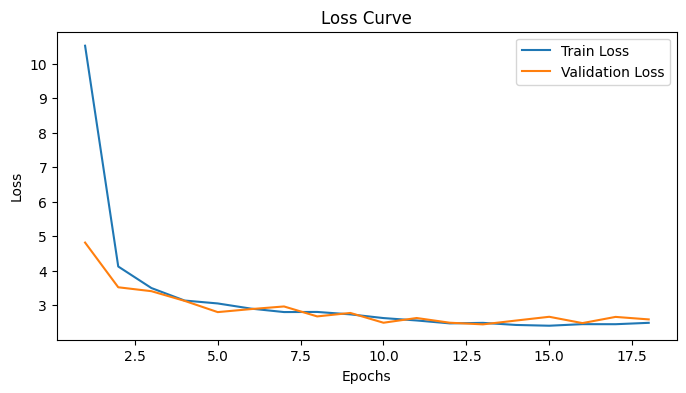

In [10]:
def plot_loss(train_losses, val_losses):
    
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 4))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

plot_loss(train_losses, val_losses)

**Evaluate the Model**

In [11]:
def evaluate(model, loader):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Evaluate on train set
y_train_true, y_train_pred = evaluate(model, train_loader)

# Evaluate on test set
y_test_true, y_test_pred = evaluate(model, test_loader)

# Print metrics
accuracy_train = accuracy_score(y_train_true, y_train_pred)
accuracy_test = accuracy_score(y_test_true, y_test_pred)
f1_test = f1_score(y_test_true, y_test_pred, average='weighted')

print(f'Training Accuracy: {accuracy_train:.3f}')
print(f'Test Accuracy: {accuracy_test:.3f}')
print(f'F1 Score: {f1_test:.3f}')
print("Classification Report:")
print(classification_report(y_test_true, y_test_pred, zero_division=0))

Training Accuracy: 0.598
Test Accuracy: 0.595
F1 Score: 0.627
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.64      0.39       212
           1       0.32      0.35      0.33       424
           2       0.24      0.41      0.30       437
           3       0.90      0.69      0.78      2715
           4       0.40      0.41      0.41       492

    accuracy                           0.59      4280
   macro avg       0.43      0.50      0.44      4280
weighted avg       0.69      0.59      0.63      4280

